In [1]:
import pandas as pd
import os
import timesfm
import chronos
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

HORIZON_LEN = 168 # horizonte con el que predecimos
CONTEXT_LEN = 288 # contexto

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


c:\Users\Asier\miniconda3\envs\fforma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM.


In [2]:
# For PyTorch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          context_len=CONTEXT_LEN,  # Example input length
          horizon_len=HORIZON_LEN,  # Example output length
          backend='gpu',
          per_core_batch_size=32,
          input_patch_len=32,
          output_patch_len=128,
          num_layers=50,
          model_dims=1280,
          
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [ ]:
pipeline = chronos.BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

c:\Users\Asier\miniconda3\envs\fforma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Asier\miniconda3\envs\fforma\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asier\.cache\huggingface\hub\models--amazon--chronos-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activat

TimesFM fixed


In [32]:
folder = "../../goi4_pst/imp_csv/"
timesfm_folder = "../../Resultados/TimesFM/"

all_mapes = []
all_rmses = []
all_ids = []
# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(folder):
    preds = pd.DataFrame(columns=['id', 'timestamp', 'pred', 'real', 'mape', 'rmse'])

    if filename.endswith('.csv'):
        file_path = os.path.join(folder, filename)

        try:
            # Leer el archivo CSV
            df = pd.read_csv(file_path, index_col=None)

            # Verificar que las columnas necesarias estén presentes
            if all(col in df.columns for col in ['timestamp', 'kWh', 'imputed']):
                file_id = os.path.splitext(filename)[0]

                # Convertir la columna 'timestamp' a datetimea
                df['timestamp'] = pd.to_datetime(df['timestamp'])

                # Seleccionar solo las columnas necesarias
                df = df[['timestamp', 'kWh', 'imputed']]
                df = df[df['kWh'] != 0]


                #* ejecutar aqui la prediccion e ir añadiendo resultados

                dataframe_original = df.copy() 
                dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy() #quitando datos a predecir
                dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy() #datos a predecir

                input_df = dataframe_remove  # Cambia el índice según la serie que deseas usar

                # Reset the index to make 'timestamp' a column again
                input_df.reset_index(inplace=True)

                # Renombrar columnas para cumplir con los requisitos de timesfm
                input_df.rename(columns={"timestamp": "ds", "kWh": "kWh"}, inplace=True)

                # Agregar una columna 'unique_id'
                input_df['unique_id'] = 'series_1'  # Asigna un ID único para esta serie

                # Pronosticar
                forecast_df = tfm.forecast_on_df(
                    inputs=input_df,
                    freq="h",  # hourly
                    value_name="kWh",
                    num_jobs=-1,
                )

                prediccion = forecast_df.copy()
                prediccion = prediccion.iloc[:,:3]

                y_true = dataframe_rdata['kWh'].values  # Esto ya es un array de NumPy, no necesitas .values
                y_pred = prediccion['timesfm'].values   # Lo mismo aquí
                
                # Asegúrate de que ambos DataFrames tengan el mismo índice
                dataframe_rdata = dataframe_rdata.reset_index(drop=True)
                prediccion = prediccion.reset_index(drop=True)


                # Calcular MAPE usando solo los valores donde y_true no es cero
                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

                # Crear un nuevo DataFrame con la nueva fila
                all_mapes.append(mape)
                all_rmses.append(rmse)
                all_ids.append(file_id)

                pred_row = pd.DataFrame({
                    'id': [file_id] * HORIZON_LEN,  # Replicar 'filename' para cada fila
                    'timestamp': prediccion['ds'],
                    'pred': y_pred,
                    'real': y_true,
                    'mape': [mape] * HORIZON_LEN,
                    'rmse': [rmse] * HORIZON_LEN

                })
              
                preds_file = os.path.join(timesfm_folder, 'preds', 'fixed', filename)
                

                pred_row.to_csv(preds_file, index=False)
                print(f"Prediccion de {filename} guardado correctamente")

         
            else:
                print(f"El archivo {filename} no contiene las columnas requeridas.")
        except Exception as e:
            print(f"Error al procesar el archivo {filename}: {e}")

errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "timesfm_fixed_errors.csv")
errors.to_csv(errors_file, index=False)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0001b3b2f18c01c62ed9b2a87de7b4e33e7836f786f7904471d8866978405c1b.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0004150214d14a2b2e6f7075531e661cf465b27ec4d0d53573866df2c97b8313.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000721f0fc6ccf02ae24b67393979513171f2abc119af07a7abed20ca303b665.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0009b156f2a1213a137c150f4787150384938eac15cc2044a10c797d98667a91.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000bf84faacf921b55bd4ec4aecda599754e9017e150091d330a

KeyboardInterrupt: 

In [33]:
errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "timesfm_fixed_errors.csv")
errors.to_csv(errors_file, index=False)

TimesFM random

In [6]:
folder = "../../goi4_pst/imp_csv/"
timesfm_folder = "../../Resultados/TimesFM/"

all_mapes = []
all_rmses = []
all_ids = []
# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(folder):
    preds = pd.DataFrame(columns=['id', 'timestamp', 'pred', 'real', 'mape', 'rmse'])

    if filename.endswith('.csv') and filename in os.listdir(os.path.join(timesfm_folder, "preds", "fixed")):
        file_path = os.path.join(folder, filename)

        try:
            # Leer el archivo CSV
            dataframe_original = pd.read_csv(file_path, index_col=None)

            # Verificar que las columnas necesarias estén presentes
            if all(col in dataframe_original.columns for col in ['timestamp', 'kWh', 'imputed']):
                file_id = os.path.splitext(filename)[0]

                # Convertir la columna 'timestamp' a datetimea
                dataframe_original['timestamp'] = pd.to_datetime(dataframe_original['timestamp'])

                # Seleccionar solo las columnas necesarias
                dataframe_original = dataframe_original[['timestamp', 'kWh', 'imputed']]
                dataframe_original = dataframe_original[dataframe_original['kWh'] != 0]


                #* ejecutar aqui la prediccion e ir añadiendo resultados
                if len(dataframe_original) < CONTEXT_LEN+HORIZON_LEN: #168 a predecir y 288 datos necesarios
                    print("La serie temporal es demasiado corta para pronosticar.")
                    continue
                else:
                    num = random.randint(CONTEXT_LEN,len(dataframe_original)-1)

                dataframe_original = dataframe_original.iloc[:num].copy()
                dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy() #quitando datos a predecir
                dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy() #datos a predecir

                input_df = dataframe_remove  # Cambia el índice según la serie que deseas usar

                # Reset the index to make 'timestamp' a column again
                input_df.reset_index(inplace=True)

                # Renombrar columnas para cumplir con los requisitos de timesfm
                input_df.rename(columns={"timestamp": "ds", "kWh": "kWh"}, inplace=True)

                # Agregar una columna 'unique_id'
                input_df['unique_id'] = 'series_1'  # Asigna un ID único para esta serie

                # Pronosticar
                forecast_df = tfm.forecast_on_df(
                    inputs=input_df,
                    freq="h",  # hourly
                    value_name="kWh",
                    num_jobs=-1,
                )

                prediccion = forecast_df.copy()
                prediccion = prediccion.iloc[:,:3]

                y_true = dataframe_rdata['kWh'].values  # Esto ya es un array de NumPy, no necesitas .values
                y_pred = prediccion['timesfm'].values   # Lo mismo aquí
                
                # Asegúrate de que ambos DataFrames tengan el mismo índice
                dataframe_rdata = dataframe_rdata.reset_index(drop=True)
                prediccion = prediccion.reset_index(drop=True)


                # Calcular MAPE usando solo los valores donde y_true no es cero
                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

                # Crear un nuevo DataFrame con la nueva fila
                all_mapes.append(mape)
                all_rmses.append(rmse)
                all_ids.append(file_id)

                pred_row = pd.DataFrame({
                    'id': [file_id] * HORIZON_LEN,  # Replicar 'filename' para cada fila
                    'timestamp': prediccion['ds'],
                    'pred': y_pred,
                    'real': y_true,
                    'mape': [mape] * HORIZON_LEN,
                    'rmse': [rmse] * HORIZON_LEN

                })
              
                preds_file = os.path.join(timesfm_folder, 'preds', 'random', filename)
                

                pred_row.to_csv(preds_file, index=False)
                print(f"Prediccion de {filename} guardado correctamente")

         
            else:
                print(f"El archivo {filename} no contiene las columnas requeridas.")
        except Exception as e:
            print(f"Error al procesar el archivo {filename}: {e}")

errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "timesfm_random_errors.csv")
errors.to_csv(errors_file, index=False)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0001b3b2f18c01c62ed9b2a87de7b4e33e7836f786f7904471d8866978405c1b.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0004150214d14a2b2e6f7075531e661cf465b27ec4d0d53573866df2c97b8313.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000721f0fc6ccf02ae24b67393979513171f2abc119af07a7abed20ca303b665.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0009b156f2a1213a137c150f4787150384938eac15cc2044a10c797d98667a91.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000bf84faacf921b55bd4ec4aecda599754e9017e150091d330a

Chronos (falta adaptar)

In [ ]:

#Código de las series temporales cargadas (fixed)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random # Import the random module

debug= False

# Listas para almacenar los resultados
all_forecasts = []
all_merged_dfs = []
mapes_tfm = []
rmses_tfm = []
mapes_chronos = []
rmses_chronos = []

# Iterar sobre cada serie en dataframes
for idx, dataframe_original in enumerate(dataframes):
    print(f"Procesando serie temporal {idx + 1}")

    #Comprobar si la serie temporal tiene una duración mayor que una semana + datos necesarios a proporcionar a timesfm
    if len(dataframe_original) < context_len+horizon_len: #168 a predecir y 288 datos necesarios
        print("La serie temporal es demasiado corta para pronosticar.")
        continue
    else:
        num = random.randint(context_len,len(dataframe_original)-1)
    # Crear copias y particionar los datos
    dataframe_original = dataframe_original.iloc[:num].copy()
    dataframe_remove = dataframe_original.iloc[:-168].copy()
    dataframe_rdata = dataframe_original.iloc[-168:].copy()

    # Establecer 'timestamp' como índice y renombrar para cumplir con timesfm
    dataframe_remove = dataframe_remove.rename(columns={"timestamp": "ds", "kWh": "kWh"})
    dataframe_remove['unique_id'] = f'series_{idx + 1}'

    # Pronosticar con TimesFM
    forecast_timesfm = tfm.forecast_on_df(
        inputs=dataframe_remove,
        freq="h",
        value_name="kWh",
        num_jobs=-1,
    )
    print("Procesado con TimesFM")

    # Paso 1: Obtener el último timestamp del dataframe_remove
    last_timestamp = pd.to_datetime(dataframe_remove['ds'].iloc[-1])

    # Paso 2: Generar un rango de fechas para el pronóstico
    forecast_timestamps = pd.date_range(
        start=last_timestamp + pd.Timedelta(hours=1),  # El siguiente periodo
        periods=168,  # Longitud del pronóstico
        freq="H"  # Frecuencia horaria
    )

    # Paso 3: Pronosticar con Chronos
    quantiles, mean = pipeline.predict_quantiles(
        context=torch.tensor(dataframe_remove['kWh'].values),
        prediction_length=168,
        quantile_levels=[0.5],
    )

    # Paso 4: Convertir el pronóstico en un DataFrame con timestamps
    forecast_chronos = pd.DataFrame({
        "timestamp": forecast_timestamps,
        "forecast": mean.flatten().numpy()
    })

    print("Procesado con Chronos")

    # Seleccionar las columnas deseadas del pronóstico
    prediction_tfm = forecast_timesfm[['ds', 'timesfm']].copy()
    prediction_chronos = forecast_chronos[['timestamp','forecast']].copy()
    if debug:
        # Gráfica para cada serie temporal
        plt.figure(figsize=(12, 6))
        plt.plot(dataframe_rdata['timestamp'], dataframe_rdata['kWh'], marker='o', linestyle='-', color='b', label='Consumo Real (kWh)')
        plt.plot(prediction_tfm['ds'], prediction_tfm['timesfm'],  marker='x', linestyle='--', color='r', label='Pronóstico (timesfm)')
        plt.plot(prediction_chronos['timestamp'], prediction_chronos['forecast'],  marker='*', linestyle='--', color='green', label='Pronóstico (chronos)')
        plt.title(f'Pronóstico de Consumo de Energía (kWh) - Serie {idx + 1}')
        plt.xlabel('Fecha y Hora')
        plt.ylabel('Consumo (kWh)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


        #series temporales completa y predicción
        # Segunda gráfica
        plt.figure(figsize=(12, 6))  # Crear una nueva figura
        plt.plot(dataframe_original['timestamp'], dataframe_original['kWh'], marker='o', linestyle='-', color='b', label='Consumo Real (kWh)')
        plt.plot(prediction_tfm['ds'], prediction_tfm['timesfm'], marker='x', linestyle='--', color='r', label='Pronóstico (timesfm)')
        plt.plot(prediction_chronos['timestamp'], prediction_chronos['forecast'],  marker='*', linestyle='--', color='green', label='Pronóstico (chronos)')
        plt.title('Pronóstico de Consumo de Energía (kWh)', fontsize=16)
        plt.xlabel('Fecha y Hora', fontsize=14)
        plt.ylabel('Consumo (kWh)', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()  # Mostrar la segunda gráfica


    # Asegúrate de que ambos DataFrames tengan el mismo número de filas
    if len(dataframe_rdata) != len(prediction_tfm):
        print("Los DataFrames no tienen la misma longitud.")
    else:
        if debug:
            # Crear un scatter plot
            plt.figure(figsize=(10, 6))
            plt.scatter(dataframe_rdata['kWh'], prediction_tfm['timesfm'], alpha=0.6)

            # Añadir la recta y=x
            max_value = max(dataframe_rdata['kWh'].max(), prediction_tfm['timesfm'].max())
            plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='y=x')

            # Personalizar la gráfica
            plt.title('Scatter Plot entre Datos Reales y Predicciones')
            plt.xlabel('Datos Reales (kWh)')
            plt.ylabel('Predicciones (timesfm)')
            plt.grid(True)

            # Mostrar la gráfica
            plt.show()

    # Calcular MAPE y RMSE
    y_true = dataframe_rdata['kWh'].values
    y_pred_tfm = prediction_tfm['timesfm'].values
    y_pred_chronos = prediction_chronos['forecast'].values
    # Filtrar los valores donde y_true es cero
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered_tfm = y_pred_tfm[mask]
    y_pred_filtered_chronos = y_pred_chronos[mask]

    # Calcular MAPE usando solo los valores donde y_true no es cero
    mape_tfm = np.mean(np.abs((y_true_filtered - y_pred_filtered_tfm) / y_true_filtered)) * 100
    mape_chronos = np.mean(np.abs((y_true_filtered - y_pred_filtered_chronos) / y_true_filtered)) * 100

    rmse_tfm = np.sqrt(np.mean((y_true - y_pred_tfm) ** 2))
    rmse_chronos = np.sqrt(np.mean((y_true - y_pred_chronos) ** 2))

    mapes_tfm.append(mape_tfm)
    rmses_tfm.append(rmse_tfm)
    mapes_chronos.append(mape_chronos)
    rmses_chronos.append(rmse_chronos)

    # Emparejar datos reales y predichos
    dataframe_rdata = dataframe_rdata.rename(columns={"timestamp": "ds"})
    merged_df = pd.merge(dataframe_rdata[['ds', 'kWh']], prediction_tfm, on='ds', how='inner')
    merged_df = merged_df[['ds', 'kWh', 'timesfm']]
    all_merged_dfs.append(merged_df)
    all_forecasts.append(prediction_tfm)
    if debug:
        # Imprimir resultados de MAPE y RMSE para cada serie
        print(f"MAPE for series {idx + 1} under TimesFM: {mape_tfm:.2f}%")
        print(f"RMSE for series {idx + 1} under TimesFM: {rmse_tfm:.4f}")
        print(f"MAPE for series {idx + 1} under Chronos: {mape_chronos:.2f}%")
        print(f"RMSE for series {idx + 1} under Chronos: {rmse_chronos:.4f}")

Prueba con un solo archivo

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


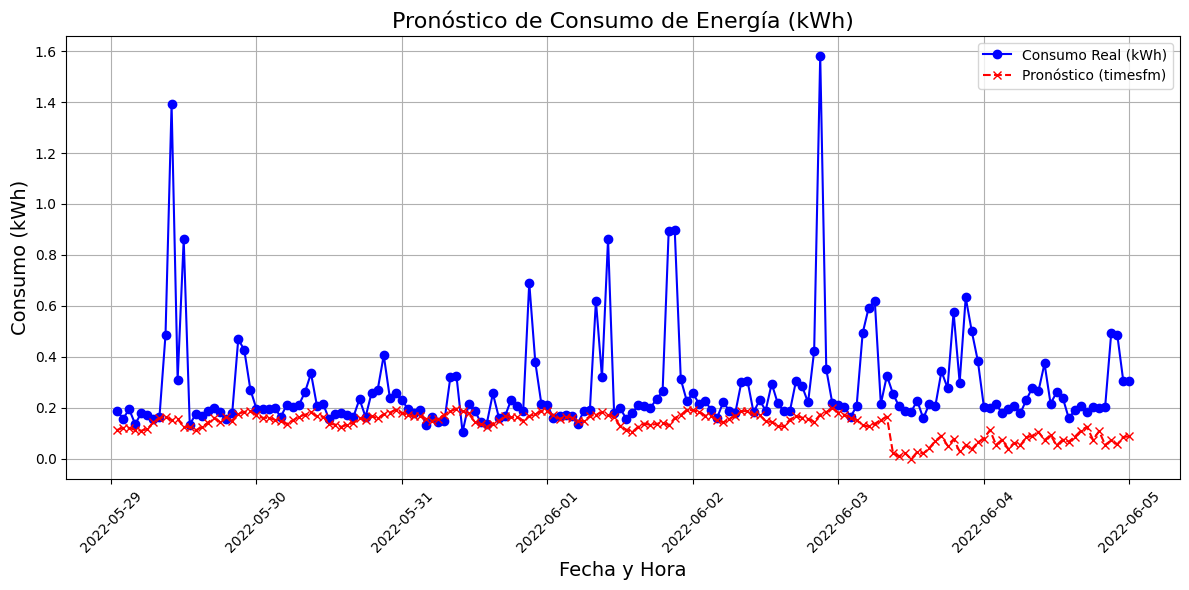

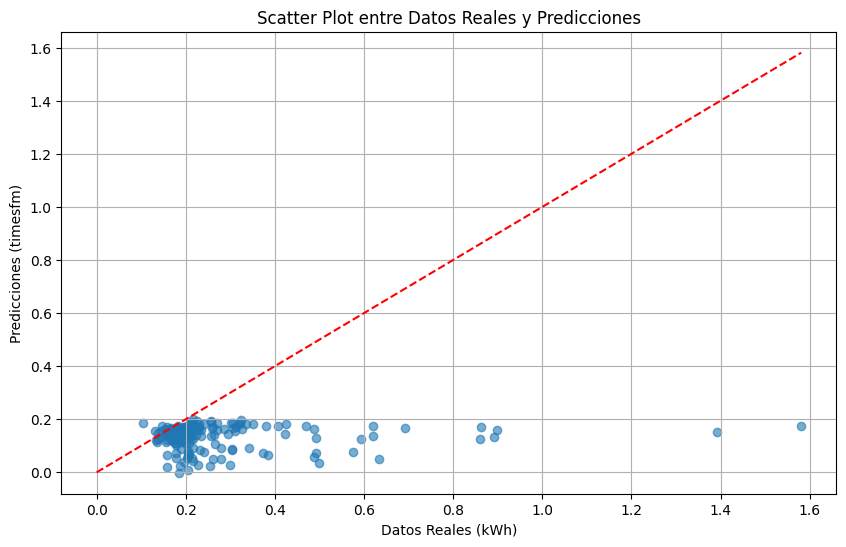

MAPE: nan%
RMSE: nan


,unique_id,ds,timesfm
0,series_1,2022-05-29 01:00:00,0.112690
1,series_1,2022-05-29 02:00:00,0.120995
2,series_1,2022-05-29 03:00:00,0.121059
3,series_1,2022-05-29 04:00:00,0.112929
4,series_1,2022-05-29 05:00:00,0.109935
...,...,...,...
163,series_1,2022-06-04 20:00:00,0.054543
164,series_1,2022-06-04 21:00:00,0.071708
165,series_1,2022-06-04 22:00:00,0.055926
166,series_1,2022-06-04 23:00:00,0.085348


In [14]:
file = "../../goi4_pst/imp_csv/000bf84faacf921b55bd4ec4aecda599754e9017e150091d330afc038f0fab11.csv"

df = pd.read_csv(file, index_col=None)
if all(col in df.columns for col in ['timestamp', 'kWh', 'imputed']):
                # Convertir la columna 'timestamp' a datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])

                # Seleccionar solo las columnas necesarias
                df = df[['timestamp', 'kWh', 'imputed']]



dataframe_original = df.copy() #todo
dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy() #quitando datos a predecir
dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy() #datos a predecir




input_df = dataframe_remove  # Cambia el índice según la serie que deseas usar

# Reset the index to make 'timestamp' a column again
input_df.reset_index(inplace=True)

# Renombrar columnas para cumplir con los requisitos de timesfm
input_df.rename(columns={"timestamp": "ds", "kWh": "kWh"}, inplace=True)

# Agregar una columna 'unique_id'
input_df['unique_id'] = 'series_1'  # Asigna un ID único para esta serie

# Pronosticar
forecast_df = tfm.forecast_on_df(
    inputs=input_df,
    freq="h",  # hourly
    value_name="kWh",
    num_jobs=-1,
)


prediccion = forecast_df.copy()
prediccion = prediccion.iloc[:,:3]


# Primera gráfica
plt.figure(figsize=(12, 6))  # Crear una nueva figura
plt.plot(dataframe_rdata['timestamp'], dataframe_rdata['kWh'], marker='o', linestyle='-', color='b', label='Consumo Real (kWh)')
plt.plot(prediccion['ds'], prediccion['timesfm'], marker='x', linestyle='--', color='r', label='Pronóstico (timesfm)')
plt.title('Pronóstico de Consumo de Energía (kWh)', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=14)
plt.ylabel('Consumo (kWh)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  # Mostrar la primera gráfica



# Supongamos que dataframe_rdata tiene los valores reales y prediccion tiene los valores predichos
y_true = dataframe_rdata['kWh'] # Valores reales
y_pred = prediccion['timesfm']   # Valores predichos

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcular RMSE
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# Asegúrate de que ambos DataFrames tengan el mismo número de filas
if len(dataframe_rdata) != len(prediccion):
    print("Los DataFrames no tienen la misma longitud.")
else:
    # Crear un scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(dataframe_rdata['kWh'], prediccion['timesfm'], alpha=0.6)

    # Añadir la recta y=x
    max_value = max(dataframe_rdata['kWh'].max(), prediccion['timesfm'].max())
    plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='y=x')

    # Personalizar la gráfica
    plt.title('Scatter Plot entre Datos Reales y Predicciones')
    plt.xlabel('Datos Reales (kWh)')
    plt.ylabel('Predicciones (timesfm)')
    plt.grid(True)

    # Mostrar la gráfica
    plt.show()

# Mostrar resultados
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.4f}')


prediccion

In [18]:
y_true[y_true != 0]

8713    0.189
8714    0.157
8715    0.194
8716    0.136
8717    0.179
        ...  
8876    0.203
8877    0.492
8878    0.487
8879    0.304
8880    0.304
Name: kWh, Length: 168, dtype: float64